# 2D MoM for Rectangular Plate 

## Import Packages

In [3]:
using ForwardDiff
using QuadGK
using HCubature 
using StaticArrays 
using LinearAlgebra 
using BenchmarkTools
using Plots

In [2]:
# a point in 3D is a tuple of 3 coordinates 
# we here introduce static vectors that appear to be vital to reduce the number of allocations 
const Point3D = SVector{3,Float64};

## Section 1: Introduction 

The <b>goal</b> here is to arrive a small proof-of-concept MoM using AD and quadrature. 

<b>Remark</b>
1. We integrate the singular kernel in <b>three (3)</b> spatial dimensions. The destination is set as the left-lower-front node of each destination element;
2. We employ same integration accuracy for self and non-self elememnts; 
3. We wish to obtain numbr of statistics of number of function calls; 

<b>Use of Julia</b>

In [4]:
# use of the macro @view 
m = [1;2;3;4]
m1 = @view m[1:2]
m2 = @view m[3:4]
m2[1]

3

In [5]:
# use the function mapreduce() to 2D array of 3D-vectors
A = Array{Point3D}(undef,2,2)
A[1,1] = Point3D(-1.,0.,0.)  
A[1,2] = Point3D(-2.,0.,0.)
A[2,1] = Point3D(-1.,0.,0.)  
A[2,2] = Point3D(-2.,0.,0.)
A

map(x->2*x,A)

mapreduce(x->2*x,+,A)

3-element SVector{3, Float64} with indices SOneTo(3):
 -12.0
   0.0
   0.0

## Section 2: Struct Definition for Element and Mesh 

### Section 1.2: Data Structures for Q0 rectangular elements 

1. uniform mesh consisting of $ne = nx \cdot ny$ 3D hexahedral elements with constant thickness;
2. $mx$: vector of $ne$ elements holding constant value of magnetization in $x$-direction; 
3. $my$: vector of $ne$ elements holding constant value of magnetization in $y$-direction;
4. $m = [mx, my]$: vector formed by concatenation of $mx$ and $my$; 
5. $(i,j)$: tuple coding $i$th-$j$th-element in the mesh for $1 \leq i \leq nx$ and $1 \leq j \leq ny$;
6. $I = nx*(j-1)+i$: linearization of $(i,j)$ tuple to retrieve information from the vector $mx$ and $my$; 

In [6]:
# struct to hold a single mesh element
struct Element
  p1::Point3D                  # lower-left-front node of the block  
  i::Int64                     # global index first node
  j::Int64                     # global index second node
  I::Int64                     # global index third node
  xs::Float64                  # left (start) point of the element 
  ys::Float64                  # lower (start) point of the element 
  zs::Float64                  # front (start) point of the element     
  xe::Float64                  # right (end) point of the element 
  ye::Float64                  # top (end) point of the element  
  ze::Float64                  # back (end) point of the element       
end

# struct to hold entire mesh
struct Mesh
  nx::Int64                    # number of elements in the x-direction 
  ny::Int64                    # number of elements in the y-direction
  ne::Int64                    # total number of elements
  Elements::Array{Element,2}   # two-dimensional array of Elements 
end

In [104]:
#..sets the mesh with nx * ny elements 
function generate_mesh(nx,ny)
    
    #..set mesh spacings 
    hx = 2/nx; hy = 2/ny;  
    
    #..set thickness ion the z-direction
    thickness = 0.1
    
    #..initialized array of nx-by-ny of type Element  
    Elements = Array{Element}(undef,nx,ny)

    #..set Elements by loop over elements in the mesh.. 
    for i=1:nx 
        xs = -1+(i-1)*hx; xe = xs+hx 
        for j=1:ny 
            ys = -1+(j-1)*hy; ye = ys+hy
            I  = nx*(j-1)+i 
            p1 = Point3D(xs,ys,0)
            Elements[i,j] = Element(p1,i,j,I,xs,ys,0,xe,ye,thickness)
        end 
    end

    #..set DOF per element
    ne = nx*ny  
    
    #..Store data inside mesh struct  
    mesh = Mesh(nx,ny,ne,Elements) 

    return mesh 
end 

mesh = generate_mesh(3,3)
element = mesh.Elements[2,2]

Element([-0.33333333333333337, -0.33333333333333337, 0.0], 2, 2, 5, -0.33333333333333337, -0.33333333333333337, 0.0, 0.33333333333333326, 0.33333333333333326, 0.1)

## Section 3: Generate Mesh 

In [46]:
# input for sample call 
nx=100; ny=100;
mesh = generate_mesh(nx,ny);

## Section 4: Set Magnetization on Mesh

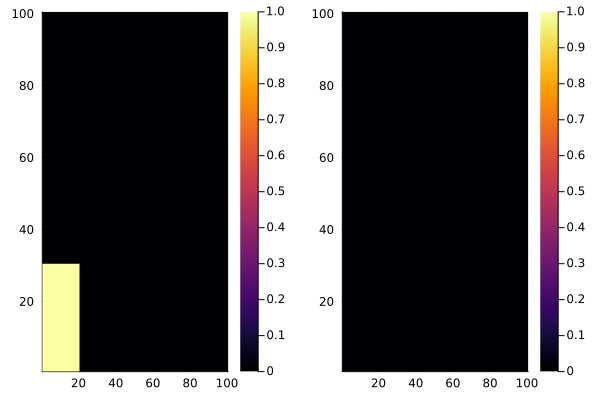

In [51]:
function set_magnization(element)
    p1 = element.p1
    xbound = abs(p1.x)<0.3
    ybound = abs(p1.y)<0.2 
    inPlate = xbound*ybound
    inAir   = 1-inPlate 
    mx = 1.0*inPlate; my = 0 
    return SVector{3,Float64}(mx,my,0)
end 

M = map(element -> set_magnization(element), mesh.Elements)

# postprocessing 
Mx = map(v->v.x, M)
My = map(v->v.y, M)

p1 = heatmap(Mx) 
p2 = heatmap(My)
plot(p1,p2)

## Section 5: All Functions

To further specify input, output and input-output relation for all functions. 

In [108]:
#..sets magnitization on single source element
function magnetization(elementp,M)
    I = elementp.I  
    ne = div(length(M),2)
    mx = @view M[1:ne]
    my = @view M[ne+1:2*ne]
    return SVector{3,Float64}(mx[I],my[I],0)
end

#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,M) 
    Mp  = magnetization(elementp,M)
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

#..sets vp contribution on source element by cubature of vp_density 
function vp_source(element,elementp,mesh,M)
    r  = element.p1
    (; p1, i, j, I, xs, ys, zs, xe, ye, ze) = elementp 
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ys,zs), (xe,ye,ze))[1]
end

#..set vp on destination element by mapreduce over all source elements  
function vp_destination(element,mesh,M) 
    vp_dest = mapreduce(elementp->vp_source(element,elementp,mesh,M),+,mesh.Elements)
end

#..set vp on mesh by map over all destination elements in the mesh 
function vp_mesh(mesh,M)
    vp = map(element->vp_destination(element,mesh,M),mesh.Elements)
end 

vp_mesh (generic function with 1 method)

## Section 6: Testing Individual Functions 

In [94]:
#..sets magnitization on single source element
function magnetization(elementp,M)
    I = elementp.I  
    ne = div(length(M),2)
    mx = @view M[1:ne]
    my = @view M[ne+1:2*ne]
    return SVector{3,Float64}(mx[I],my[I],0)
end

# input for sample call 
nx=3; ny=3;
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
mesh = generate_mesh(3,3)
element = mesh.Elements[2,2]
magnetization(element,M)
#@code_warntype magnetization(element,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 1.0
 0.0

In [95]:
#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,M) 
    Mp  = magnetization(elementp,M)
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
element  = mesh.Elements[1,1]
r = element.p1 
elementp = mesh.Elements[2,2]
rp = Point3D((elementp.xs+elementp.xe)/2,(elementp.ys+elementp.ye)/2,(elementp.zs+elementp.ze)/2) 
vp_kernel(r,rp,elementp,M)
#@code_warntype vp_kernel(r,rp,elementp,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.14036728673802953
  0.14036728673802953
  0.0

In [96]:
#..sets vp contribution on source element by cubature of vp_density 
function vp_source(element,elementp,mesh,M)
    r  = element.p1 
    xs = elementp.xs; xe = elementp.xe
    ys = elementp.ys; ye = elementp.ye
    zs = elementp.zs; ze = elementp.ze
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ys,zs), (xe,ye,ze))[1]
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
element  = mesh.Elements[1,1]
elementp = mesh.Elements[1,1]
vp_source(element,elementp,mesh,M)
#@code_warntype vp_source(element,elementp,mesh,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.1362495069152708
  0.1362495069152708
 -1.7042538402329514e-13

In [97]:
#..set vp on destination element by mapreduce over all source elements  
function vp_destination(element,mesh,M) 
    vp_dest = mapreduce(elementp->vp_source(element,elementp,mesh,M),+,mesh.Elements)
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
element  = mesh.Elements[1,1]
vp_dest = vp_destination(element,mesh,M)
#@code_warntype vp_destination(element,mesh,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.15002323326006367
  0.15002323326006367
 -1.6943879872571236e-13

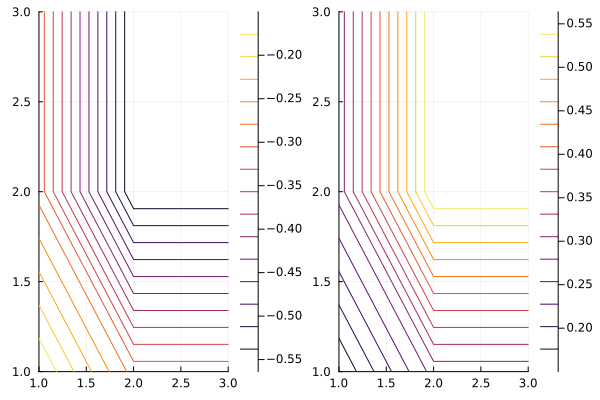

In [98]:
#..set vp on mesh by map over all destination elements in the mesh 
function vp_mesh(mesh,M)
    vp = map(element->vp_destination(element,mesh,M),mesh.Elements)
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
vp_array = vp_mesh(mesh,M)
#@code_warntype vp_mesh(mesh,M)

# postprocessing 
Ax = map(v->v.x, vp_array)
Ay = map(v->v.y, vp_array)

p1 = contour(Ax) 
p2 = contour(Ay)
plot(p1,p2)

## Section 7: Apply to 2D Thin Plate 

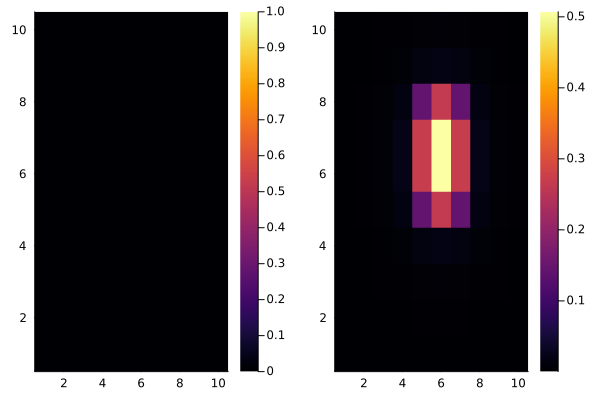

In [109]:
# input for sample call 
nx=10; ny=10;
mesh = generate_mesh(nx,ny);

M_array = map(element -> set_magnization(element), mesh.Elements)

mx = vec(map(v->v.x, M_array)); my = vec(map(v->v.y, M_array));  M = [mx;my]

# sample call
vp_array = vp_mesh(mesh,M)

# postprocessing 
Ax = map(v->v.x, vp_array)
Ay = map(v->v.y, vp_array)

p1 = heatmap(Ax) 
p2 = heatmap(Ay)
plot(p1,p2)

## Section 8: Using ForwardDiff  

In [117]:
M0 = M
#Cp = ForwardDiff.jacobian(M -> vp_mesh(mesh,M), M0)

200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [116]:
function prova(mesh,M)
    map(x->x.p1,mesh.Elements)
end

prova(mesh,M)

ForwardDiff.jacobian(M -> prova(mesh,M), M0)

100×200 Matrix{SVector{3, Float64}}:
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]     [0.0, 0.0, 0.0]  [0.0, 0.0, 0.0]
 ⋮                                 ⋱    